In [1]:
from sklearn.decomposition import PCA
import numpy as np

post_data_path = 'data/stim_data/post_stim_data.npy'
pre_data_path = 'data/stim_data/pre_stim_data.npy'

post_stim   = np.load(post_data_path)
pre_stim    = np.load(pre_data_path)

In [2]:
# aggregate data
stim = np.concatenate([pre_stim, post_stim], 0)
pre_size = len(pre_stim)
post_size = len(post_stim)
print(f'Total size: {len(stim)} \t Pre size {pre_size} \t Post size {len(post_stim)}')

# pca
pca = PCA(n_components=2)
X_post = pca.fit_transform(stim) # [ 242, 3 ]

# make y
y = np.concatenate([np.zeros([pre_size, 2]), np.ones([post_size, 2])], 0)
y = y.astype(int)

Total size: 242 	 Pre size 75 	 Post size 167


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class GammaMap(nn.Module):
    '''
    Following the original paper, we set gamme to a nonlinear map (for image based experiments)
    '''
    def __init__(self, latent_dim, device = 'cuda:0'):
        super(GammaMap, self).__init__()
        self.device = device
        self.latent_dim = latent_dim
        self.gamma = nn.Parameter(torch.zeros(2, latent_dim), requires_grad=True) # [ 4, latent_dim ]
    
    def forward(self, z : torch.tensor, y : torch.tensor):
        '''
        Args:
        - z : [ B, latent_dim ]
        - y : [ B, 2 ]
        '''
        indexs  = y[:, 0].long()                        # [ B ]
        gamma   = self.gamma[indexs]                    # [ B, latent_dim ]
        out     = torch.bmm(gamma.unsqueeze(1), z.unsqueeze(2)).squeeze()   # [ B ]
        return out

    def loss(self, z : torch.tensor, y : torch.tensor):
        indexs  = y[:, 0].long()                        # [ B ]
        y_hat   = torch.rand(self.latent_dim)[indexs].to(self.device)       # [ B ]
        out     = self.forward(z, y)
        loss    = torch.sum((out - y_hat)**2)           # scalar
        return loss
    
    def transform(self, z_pred):
        '''
        Args:
        - z_pred : [ B, latent_dim ]
        '''
        # return torch.mm(z_pred, self.gamma)     # [ B, latent_dim ]
        return torch.mm(self.gamma, z_pred.T).T   # [ B, 4 ]
    
    
class GammaLoader:

    def __init__(self, z_pred : torch.tensor, y : np.array):
        self.z_pred = z_pred
        self.y      = torch.tensor(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.z_pred[idx], self.y[idx]

    
def train_gammamap(z_pred : torch.tensor, y : np.array, model : GammaMap, train_config : dict):
    '''
    Args:
    - z_pred : [ B, latent_dim ]
    '''
    # parameters
    lr              = train_config['lr']
    batch_size      = train_config['batch_size']
    num_epoch       = train_config['num_epoch']
    weight_decay    = train_config['weight_decay']
    device          = train_config['device']
    log_int         = train_config['log_int']

    model = model.to(device)
    opt = optim.Adam(model.parameters(),
                    lr= lr,
                    weight_decay = weight_decay)
    
    dl              = GammaLoader(z_pred, y)
    train_dataset   = DataLoader(dl, batch_size=batch_size, shuffle=True)
    train_losses    = []
    batch_losses    = []
    model.train()
    for epoch in range(num_epoch):
        try:
            for z, y in train_dataset:
                opt.zero_grad()
                loss = model.loss(z, y)
                loss.backward()
                opt.step()
                train_losses.append(loss.item())
                batch_losses.append(loss.item())
            if epoch % log_int == 0:
                print(f'Epoch: {epoch}\t Loss: {np.mean(batch_losses)}')
                batch_losses = []
        except KeyboardInterrupt:
            break
    return train_losses

In [5]:
# learn a linear mapping from do-interventions 
# from model.gamma_map import GammaMap, train_gammamap

gm_train_config = {
    'lr'            : 1e-2,
    'batch_size'    : 64,
    'num_epoch'     : 300,            # 300
    'weight_decay'  : 5e-4,
    'device'        : 'cuda:0',
    'log_int'       : 100
}

tran_zs = []

for _ in range(5):
    gm = GammaMap(2, device = 'cuda:0')
    # z_pred = z_pred.cpu().detach().to('cuda:0') # clean the gradients
    gm_losses = train_gammamap(torch.tensor(X_post).to('cuda:0').float(), y, gm, gm_train_config)
    tran_z = gm.transform(torch.tensor(X_post).to('cuda:0').float()).cpu().detach().numpy()    # [ B, latent_dim ] numpy.array
    tran_zs.append(tran_z)

Epoch: 0	 Loss: 24.497663378715515
Epoch: 100	 Loss: 17.61519848704338
Epoch: 200	 Loss: 16.29967967361212
Epoch: 0	 Loss: 32.54922842979431
Epoch: 100	 Loss: 16.810962871164083
Epoch: 200	 Loss: 19.23212494686246
Epoch: 0	 Loss: 34.09684157371521
Epoch: 100	 Loss: 17.93554477095604
Epoch: 200	 Loss: 17.05244034409523
Epoch: 0	 Loss: 24.797539710998535
Epoch: 100	 Loss: 18.036842744648457
Epoch: 200	 Loss: 16.285831137001516
Epoch: 0	 Loss: 36.33237284421921
Epoch: 100	 Loss: 16.741957077682017
Epoch: 200	 Loss: 16.7576359590888


C:\Users\wenbi\AppData\Local\Temp\ipykernel_34312\2905124891.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


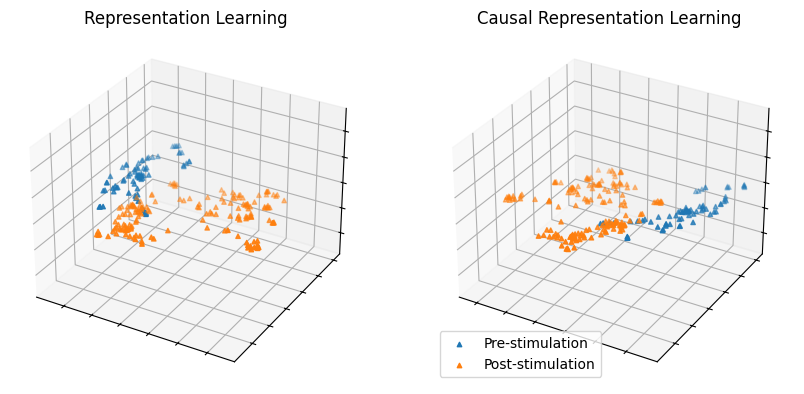

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
for i in range(2):
    if i == 0:
        ax[i].scatter(X_post[:pre_size, 0], X_post[:pre_size, 1], s=10, c='tab:blue', marker = '^', label = 'Pre-stimulation')
        ax[i].scatter(X_post[pre_size:, 0], X_post[pre_size:, 1], s=10, c='tab:orange', marker = '^', label = 'Post-stimulation')
        # ax[i].legend(loc = 'lower right')
    else:
        ax[i].scatter(tran_z[:pre_size, 0], X_post[:pre_size, 1], s=10, c='tab:blue', marker = '^', label = 'Pre-stimulation')
        ax[i].scatter(tran_z[pre_size:, 0], X_post[pre_size:, 1], s=10, c='tab:orange', marker = '^', label = 'Post-stimulation')
    ax[i].set_title('Representation Learning') if i == 0 else ax[i].set_title('Causal Representation Learning')
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_zticklabels([])
plt.tight_layout()
plt.legend(loc = 'lower left')
plt.show()